In [3]:
# detach("package:ArchR", unload=TRUE)
suppressMessages(library(ggplot2))
suppressMessages(library(dplyr))
suppressMessages(library(ArchR))
suppressMessages(library(Seurat))
suppressMessages(library(Signac))
suppressMessages(library(here))
set.seed(42)
addArchRThreads(threads = 64)

Setting default number of Parallel threads to 64.



In [9]:
proj <- loadArchRProject("./ArchRProject", showLogo = FALSE)

Successfully loaded ArchRProject!



In [17]:
## 将15个细胞类型合并为9个细胞类型
cell_combination <- list(
    "Epithelial" = c("Epithelial", "Basal"),
    "Endothelial" = c("Endothelial", "Ery & Endo mixed"),
    "Fibroblast" = c("Fibroblast"),
    "PeriVascular" = c("Pericyte", "Smooth muscle"), 
    "T cells" = c("CD4T cells", "CD8T & NK cells"), 
    "B cells" = c("B cells"), 
    "Plasmablast" = c("Plasmablast", "Plasma cells"), 
    "Myeloid" = c("Myeloid", "pDC"), 
    "Mast" = c("Mast"),
    "Unassigned" = c("Unassigned")
)

In [18]:
# 创建一个新的predictedMajorCellType列
proj$predictedMajorCellType <- proj$predictedCellType

# 遍历cell_combination，并根据每个组合进行替换
for (major_type in names(cell_combination)) {
    proj$predictedMajorCellType[proj$predictedCellType %in% cell_combination[[major_type]]] <- major_type
}

# 查看合并后的结果
table(proj$predictedMajorCellType)


     B cells  Endothelial   Epithelial   Fibroblast         Mast      Myeloid 
        1180        11571        29033        11072          502         3957 
PeriVascular  Plasmablast      T cells   Unassigned 
        4944         1102        14408         8248 

In [19]:
table(proj$predictedMajorCellType)


     B cells  Endothelial   Epithelial   Fibroblast         Mast      Myeloid 
        1180        11571        29033        11072          502         3957 
PeriVascular  Plasmablast      T cells   Unassigned 
        4944         1102        14408         8248 

In [13]:
cell_annotations <- list(
    "Myeloid" = paste0("C", c(14:16)),
    "T cells" = paste0("C", 12),
    "B cells" = paste0("C", 10),
    "Plasmablast" = paste0("C", 11),
    "Fibroblast" = paste0("C", c(21:22)),
    "PeriVascular" = paste0("C", 20),
    "Endothelial" = paste0("C", c(17:19)),
    "Mast" = paste0("C", 13),
    "Epithelial" = paste0("C", c(1:9,23:25))
)

In [14]:
## 根据cell——annotations和proj$Clusters创建proj$cellType列
# 对于cell_annotations中的每一个元素（细胞类型）返回proj$Clusters中对应的索引
idz <- lapply(cell_annotations, function(x) which(proj$Clusters %in% x))
# 创建proj$cellType列，长度为proj@cellColData的行数，初始化为NA
proj$majorType <- rep(NA, nrow(proj@cellColData))
# 遍历idz中的每一个元素，将proj$cellType中对应的索引赋值为元素的名称
for(i in names(idz)){proj$majorType[idz[[i]]] <- i}

In [15]:
table(proj$majorType)


     B cells  Endothelial   Epithelial   Fibroblast         Mast      Myeloid 
        1410        15757        29719        11228          606         4427 
PeriVascular  Plasmablast      T cells 
        5629         1264        15977 

ArchR logging to : ArchRLogs/ArchR-plotEmbedding-3f12355ded4ef0-Date-2025-02-27_Time-03-14-56.261193.log
If there is an issue, please report to github with logFile!

Getting UMAP Embedding

ColorBy = cellColData

Plotting Embedding

1 
Length of unique values greater than palette, interpolating..



ArchR logging successful to : ArchRLogs/ArchR-plotEmbedding-3f12355ded4ef0-Date-2025-02-27_Time-03-14-56.261193.log

ArchR logging to : ArchRLogs/ArchR-plotEmbedding-3f123516c12036-Date-2025-02-27_Time-03-15-05.856331.log
If there is an issue, please report to github with logFile!

Getting UMAP Embedding

ColorBy = cellColData

Plotting Embedding

1 


ArchR logging successful to : ArchRLogs/ArchR-plotEmbedding-3f123516c12036-Date-2025-02-27_Time-03-15-05.856331.log



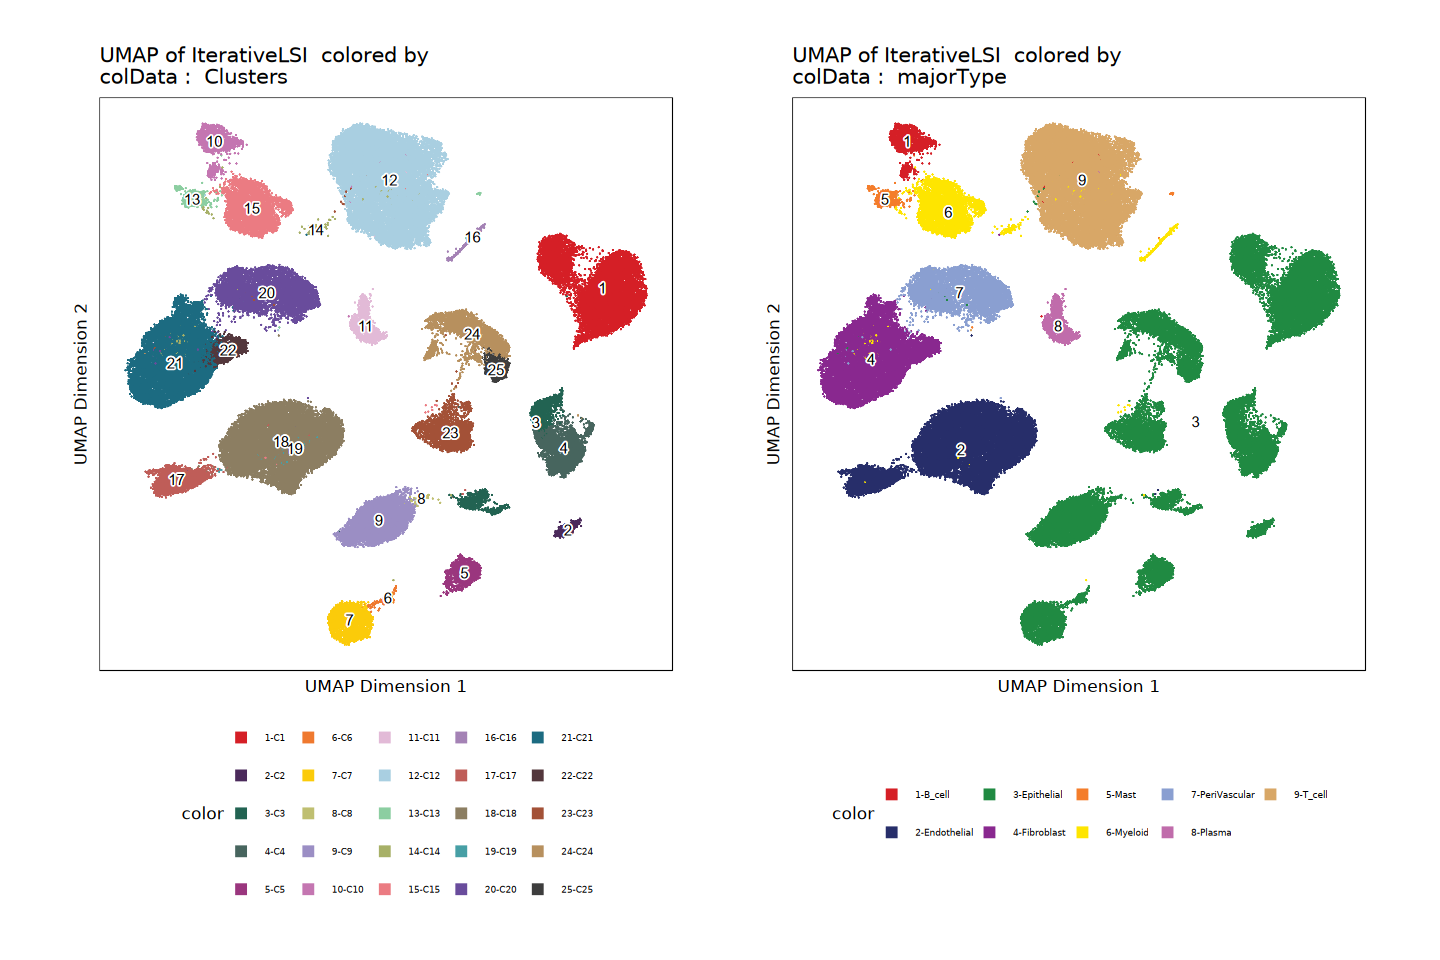

In [23]:
options(repr.plot.height = 8, repr.plot.width = 12)
p1 <- plotEmbedding(
    ArchRProj = proj, 
    colorBy = "cellColData", 
    name = "Clusters", 
    embedding = "UMAP"
    )
p2 <- plotEmbedding(
    ArchRProj = proj, 
    colorBy = "cellColData", 
    name = "majorType", 
    embedding = "UMAP"
    )
ggAlignPlots(p1, p2, type = "h")

In [24]:
## majorType 差异genes
markersGS <- getMarkerFeatures(
    ArchRProj = proj, 
    useMatrix = "GeneScoreMatrix", 
    groupBy = "majorType",
    bias = c("TSSEnrichment", "log10(nFrags)"),
    testMethod = "wilcoxon"
)

ArchR logging to : ArchRLogs/ArchR-getMarkerFeatures-3f1235758afc67-Date-2025-02-27_Time-03-15-29.89816.log
If there is an issue, please report to github with logFile!



MatrixClass = Sparse.Double.Matrix

2025-02-27 03:15:31.286363 : Matching Known Biases, 0.02 mins elapsed.



In [ ]:
saveRDS(markersGS, file = "./ArchRProject/markersGS_majorType.rds")

In [ ]:
markerList <- getMarkers(markersGS, cutOff = "FDR <= 0.05 & Log2FC >= 1.25")
markerList <- lapply(markerList, as.data.frame)
library(writexl)
## 按照MeanDiff排序
for(i in 1:length(markerList)){
    markerList[[i]] <- markerList[[i]][order(-markerList[[i]]$MeanDiff), ]
}
## 保存为Excel文件
WriteXLS::WriteXLS(markerList,
                   ExcelFileName = "./ArchRProject/markersGS_majorType.xlsx",
                   SheetNames = names(markerList))

In [ ]:
markerList <- getMarkers(markersGS, cutOff = "FDR <= 0.05 & Log2FC >= 1.25")
## Clusters差异基因，按照FDR排序，并保存为Excel文件
markerList <- lapply(markerList, as.data.frame)
for(i in 1:length(markerList)){
    markerList[[i]] <- markerList[[i]][order(markerList[[i]]$FDR), ]
}
WriteXLS::WriteXLS(markerList,
                   ExcelFileName = "./ArchRProject/markersGS_FDR_majorType.xlsx",
                   SheetNames = names(markerList))

In [ ]:
## majorType 差异peaks
markerPK <- getMarkerFeatures(
    ArchRProj = proj,
    useMatrix = "PeakMatrix", 
    groupBy = "majorType",
    bias = c("TSSEnrichment", "log10(nFrags)"),
    testMethod = "wilcoxon"
)

ArchR logging to : ArchRLogs/ArchR-getMarkerFeatures-3f12356237b5ba-Date-2025-02-26_Time-10-36-29.25489.log
If there is an issue, please report to github with logFile!



MatrixClass = Sparse.Integer.Matrix

2025-02-26 10:36:29.860068 : Matching Known Biases, 0.009 mins elapsed.



In [ ]:
saveRDS(markerPK, file = "./ArchRProject/markersPK_majorType.rds")

In [4]:
markerPK <- getMarkerFeatures(
    ArchRProj = proj,
    useMatrix = "PeakMatrix", 
    groupBy = "Sample",
    bias = c("TSSEnrichment", "log10(nFrags)"),
    testMethod = "wilcoxon"
)

ArchR logging to : ArchRLogs/ArchR-getMarkerFeatures-eeb772c98fd08-Date-2025-04-01_Time-06-55-13.882533.log
If there is an issue, please report to github with logFile!

MatrixClass = Sparse.Integer.Matrix

2025-04-01 06:55:17.650974 : Matching Known Biases, 0.057 mins elapsed.

###########
2025-04-01 06:57:36.041626 : Completed Pairwise Tests, 2.364 mins elapsed.
###########

ArchR logging successful to : ArchRLogs/ArchR-getMarkerFeatures-eeb772c98fd08-Date-2025-04-01_Time-06-55-13.882533.log



In [5]:
saveRDS(markerPK, file = "./ArchRProject/markersPK_Sample.rds")

提取上皮细胞&C15
免疫细胞没变

In [ ]:
table(proj$majorType)


      B_cell  Endothelial   Epithelial   Fibroblast         Mast      Myeloid 
        1410        15757        29719        11228          606         4427 
PeriVascular       Plasma       T_cell 
        5629         1264        15977 

In [5]:
# 获取并转换细胞元数据
cell_stats <- getCellColData(proj) %>%
  as.data.frame() %>%
  group_by(Sample, majorType) %>% 
  summarise(Count = n()) %>%
  tidyr::pivot_wider(names_from = majorType, values_from = Count, values_fill = 0) %>%
  mutate(Total = rowSums(across(where(is.numeric))))  # 计算所有数值列的总和
# 查看结果
cell_stats

`summarise()` has grouped output by 'Sample'. You can override using the
`.groups` argument.


Sample,B_cell,Endothelial,Epithelial,Fibroblast,Mast,Myeloid,PeriVascular,Plasma,T_cell,Total
<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>
10N,4,553,3936,3581,1,245,375,181,1420,10296
10T,1,105,9770,26,26,120,92,0,78,10218
11T,181,2117,663,1364,86,303,1071,14,2845,8644
12N,39,4454,1345,484,20,165,550,52,237,7346
12T,114,2736,726,1290,169,381,893,63,717,7089
13T,254,2620,3019,1319,35,431,759,114,1144,9695
18T,0,133,4906,229,65,330,70,16,319,6068
19T,48,2215,1166,828,2,276,1031,7,794,6367
20T,337,281,184,1494,38,1324,465,145,2768,7036


### subsetArchRProject函数有bug,运行devtools::install_github("GreenleafLab/ArchR", ref="dev_emptyChr", repos = BiocManager::repositories())后设置detach("package:ArchR", unload=TRUE)

### 这样安装的ArchR是1.0.2版本，plotPDF会有BUG,所以在画图的时候要重新更新为1.0.3，同时ggplot2的版本为3.5.0

In [10]:
metadata <- as.data.frame(proj@cellColData)

In [11]:
proj@cellColData$Sample

character-Rle of length 86017 with 11 runs
  Lengths:  8644  7346  7089  9695  6367 10296 10218  6068  7036  7774  5484
  Values : "11T" "12N" "12T" "13T" "19T" "10N" "10T" "18T" "20T" "21T" "22T"

In [ ]:
# 提取肿瘤细胞
tumor_clusters <- c("11T","12T", "13T", "19T","10T", "18T", "20T", "21T", "22T")
tumor_cells <- rownames(metadata)[metadata$Sample %in% tumor_clusters]
proj_tumor <- subsetArchRProject(
    ArchRProj = proj,
    cells = tumor_cells,
    outputDirectory = "./ArchRProject_tumor",
    force = TRUE,
    dropCells=FALSE
    )

In [10]:
# 提取上皮细胞
epithelial_cluster <- c("Epithelial")
epithelial_cells <- rownames(metadata)[metadata$majorType %in% epithelial_cluster]
proj_epithelial <- subsetArchRProject(
    ArchRProj = proj,
    cells = epithelial_cells,
    outputDirectory = "./ArchRProject_epithelial",
    force = TRUE,
    dropCells=FALSE
    )

Dropping ImputeWeights Since You Are Subsetting Cells! ImputeWeights is a cell-x-cell Matrix!



Copying ArchRProject to new outputDirectory : /home/hanxue/lab/scATAC/BCY_ATAC_R/joint/ArchRProject_epithelial

Copying Arrow Files...

Copying Arrow Files (1 of 11)

Copying Arrow Files (2 of 11)

Copying Arrow Files (3 of 11)

Copying Arrow Files (4 of 11)

Copying Arrow Files (5 of 11)

Copying Arrow Files (6 of 11)

Copying Arrow Files (7 of 11)

Copying Arrow Files (8 of 11)

Copying Arrow Files (9 of 11)

Copying Arrow Files (10 of 11)

Copying Arrow Files (11 of 11)

Getting ImputeWeights

No imputeWeights found, returning NULL

Copying Other Files...

Copying Other Files (1 of 20): Annotations

Copying Other Files (2 of 20): Background-Peaks.rds

Copying Other Files (3 of 20): Embeddings

Copying Other Files (4 of 20): GeneScoreMatrix.Rds

Copying Other Files (5 of 20): GroupCoverages

Copying Other Files (6 of 20): IterativeLSI

Copying Other Files (7 of 20): markersGS_FDR_majorType.xlsx

Copying Other Files (8 of 20): markersGS_FDR.xlsx

Copying Other Files (9 of 20): markers

In [11]:
# 创建完要保存！不然后面使用load函数会报错
saveArchRProject(proj_epithelial, load = FALSE)

Saving ArchRProject...



In [4]:
# 提取内皮细胞
endothelial_cluster <- c("Endothelial")
endothelial_cells <- rownames(metadata)[metadata$majorType %in% endothelial_cluster]
proj_endothelial <- subsetArchRProject(
    ArchRProj = proj,
    cells = endothelial_cells,
    outputDirectory = "./ArchRProject_endothelial",
    force = TRUE,
    dropCells=FALSE
    )

Dropping ImputeWeights Since You Are Subsetting Cells! ImputeWeights is a cell-x-cell Matrix!

Copying ArchRProject to new outputDirectory : /home/hanxue/lab/scATAC/BCY_ATAC_R/joint/ArchRProject_endothelial

Copying Arrow Files...

Copying Arrow Files (1 of 11)

Copying Arrow Files (2 of 11)

Copying Arrow Files (3 of 11)

Copying Arrow Files (4 of 11)

Copying Arrow Files (5 of 11)

Copying Arrow Files (6 of 11)

Copying Arrow Files (7 of 11)

Copying Arrow Files (8 of 11)

Copying Arrow Files (9 of 11)

Copying Arrow Files (10 of 11)

Copying Arrow Files (11 of 11)

Getting ImputeWeights

No imputeWeights found, returning NULL

Copying Other Files...

Copying Other Files (1 of 18): Annotations

Copying Other Files (2 of 18): Background-Peaks.rds

Copying Other Files (3 of 18): Embeddings

Copying Other Files (4 of 18): GeneScoreMatrix.Rds

Copying Other Files (5 of 18): GroupCoverages

Copying Other Files (6 of 18): IterativeLSI

Copying Other Files (7 of 18): markersGS_FDR_majorType

In [6]:
# 创建完要保存！不然后面使用load函数会报错
saveArchRProject(proj_endothelial, load = FALSE)

Saving ArchRProject...



In [ ]:
# 提取免疫细胞
immune_cluster <- c("T_cell", "B_cell", "Myeloid", "Mast", "Plasma")
immune_cells <- rownames(metadata)[metadata$majorType %in% immune_cluster]
proj_immune <- subsetArchRProject(
    ArchRProj = proj,
    cells = immune_cells,
    outputDirectory = "./ArchRProject_immune",
    force = TRUE,
    dropCells=FALSE
    )

Dropping ImputeWeights Since You Are Subsetting Cells! ImputeWeights is a cell-x-cell Matrix!

Copying ArchRProject to new outputDirectory : /home/hanxue/lab/scATAC/BCY_ATAC_R/joint/ArchRProject_immune

Copying Arrow Files...

Copying Arrow Files (1 of 11)

Copying Arrow Files (2 of 11)

Copying Arrow Files (3 of 11)

Copying Arrow Files (4 of 11)

Copying Arrow Files (5 of 11)

Copying Arrow Files (6 of 11)

Copying Arrow Files (7 of 11)

Copying Arrow Files (8 of 11)

Copying Arrow Files (9 of 11)

Copying Arrow Files (10 of 11)

Copying Arrow Files (11 of 11)

Getting ImputeWeights

No imputeWeights found, returning NULL

Copying Other Files...

Copying Other Files (1 of 16): Annotations

Copying Other Files (2 of 16): Background-Peaks.rds

Copying Other Files (3 of 16): Embeddings

Copying Other Files (4 of 16): GeneScoreMatrix.Rds

Copying Other Files (5 of 16): GroupCoverages

Copying Other Files (6 of 16): IterativeLSI

Copying Other Files (7 of 16): markersGS_FDR_majorType.xlsx

In [ ]:
saveArchRProject(proj_immune, load = FALSE)

Saving ArchRProject...



In [ ]:
# 提取T细胞
T_cluster <- c("T_cell")
T_cells <- rownames(metadata)[metadata$majorType %in% T_cluster]
proj_T <- subsetArchRProject(
    ArchRProj = proj,
    cells = T_cells,
    outputDirectory = "./ArchRProject_T",
    force = TRUE,
    dropCells=FALSE
    )

Dropping ImputeWeights Since You Are Subsetting Cells! ImputeWeights is a cell-x-cell Matrix!

Copying ArchRProject to new outputDirectory : /home/hanxue/lab/scATAC/BCY_ATAC_R/joint/ArchRProject_T

Copying Arrow Files...

Copying Arrow Files (1 of 11)

Copying Arrow Files (2 of 11)

Copying Arrow Files (3 of 11)

Copying Arrow Files (4 of 11)

Copying Arrow Files (5 of 11)

Copying Arrow Files (6 of 11)

Copying Arrow Files (7 of 11)

Copying Arrow Files (8 of 11)

Copying Arrow Files (9 of 11)

Copying Arrow Files (10 of 11)

Copying Arrow Files (11 of 11)

Getting ImputeWeights

No imputeWeights found, returning NULL

Copying Other Files...

Copying Other Files (1 of 16): Annotations

Copying Other Files (2 of 16): Background-Peaks.rds

Copying Other Files (3 of 16): Embeddings

Copying Other Files (4 of 16): GeneScoreMatrix.Rds

Copying Other Files (5 of 16): GroupCoverages

Copying Other Files (6 of 16): IterativeLSI

Copying Other Files (7 of 16): markersGS_FDR_majorType.xlsx

Cop

In [ ]:
saveArchRProject(proj_T, load = FALSE)

Saving ArchRProject...



In [ ]:
# 提取髓系细胞
Myeloid_cluster <- c("Myeloid")
Myeloid_cells <- rownames(metadata)[metadata$majorType %in% Myeloid_cluster]
proj_Myeloid <- subsetArchRProject(
    ArchRProj = proj,
    cells = Myeloid_cells,
    outputDirectory = "./ArchRProject_Myeloid",
    force = TRUE,
    dropCells=FALSE
    )

Dropping ImputeWeights Since You Are Subsetting Cells! ImputeWeights is a cell-x-cell Matrix!

Copying ArchRProject to new outputDirectory : /home/hanxue/lab/scATAC/BCY_ATAC_R/joint/ArchRProject_Myeloid

Copying Arrow Files...

Copying Arrow Files (1 of 11)

Copying Arrow Files (2 of 11)

Copying Arrow Files (3 of 11)

Copying Arrow Files (4 of 11)

Copying Arrow Files (5 of 11)

Copying Arrow Files (6 of 11)

Copying Arrow Files (7 of 11)

Copying Arrow Files (8 of 11)

Copying Arrow Files (9 of 11)

Copying Arrow Files (10 of 11)

Copying Arrow Files (11 of 11)

Getting ImputeWeights

No imputeWeights found, returning NULL

Copying Other Files...

Copying Other Files (1 of 16): Annotations

Copying Other Files (2 of 16): Background-Peaks.rds

Copying Other Files (3 of 16): Embeddings

Copying Other Files (4 of 16): GeneScoreMatrix.Rds

Copying Other Files (5 of 16): GroupCoverages

Copying Other Files (6 of 16): IterativeLSI

Copying Other Files (7 of 16): markersGS_FDR_majorType.xls

In [ ]:
saveArchRProject(proj_Myeloid, load = FALSE)

Saving ArchRProject...



In [8]:
# 提取成纤维细胞
Fibro_cluster <- c("Fibroblast")
Fibro_cells  <- rownames(metadata)[metadata$majorType %in% Fibro_cluster]
proj_Fibro <- subsetArchRProject(
    ArchRProj = proj,
    cells = Fibro_cells,
    outputDirectory = "./ArchRProject_Fibro",
    force = TRUE,
    dropCells=FALSE
    )

Dropping ImputeWeights Since You Are Subsetting Cells! ImputeWeights is a cell-x-cell Matrix!

Copying ArchRProject to new outputDirectory : /home/hanxue/lab/scATAC/BCY_ATAC_R/joint/ArchRProject_Fibro

Copying Arrow Files...

Copying Arrow Files (1 of 11)

Copying Arrow Files (2 of 11)

Copying Arrow Files (3 of 11)

Copying Arrow Files (4 of 11)

Copying Arrow Files (5 of 11)

Copying Arrow Files (6 of 11)

Copying Arrow Files (7 of 11)

Copying Arrow Files (8 of 11)

Copying Arrow Files (9 of 11)

Copying Arrow Files (10 of 11)

Copying Arrow Files (11 of 11)

Getting ImputeWeights

No imputeWeights found, returning NULL

Copying Other Files...

Copying Other Files (1 of 18): Annotations

Copying Other Files (2 of 18): Background-Peaks.rds

Copying Other Files (3 of 18): Embeddings

Copying Other Files (4 of 18): GeneScoreMatrix.Rds

Copying Other Files (5 of 18): GroupCoverages

Copying Other Files (6 of 18): IterativeLSI

Copying Other Files (7 of 18): markersGS_FDR_majorType.xlsx


In [9]:
saveArchRProject(proj_Fibro, load = FALSE)

Saving ArchRProject...



In [3]:
proj <- addCoAccessibility(
    ArchRProj = proj,
    reducedDims = "IterativeLSI"
)

ArchR logging to : ArchRLogs/ArchR-addCoAccessibility-3ff4d14cf479b0-Date-2025-04-20_Time-13-36-25.846831.log
If there is an issue, please report to github with logFile!

Filtering 1 dims correlated > 0.75 to log10(depth + 1)

2025-04-20 13:36:27.103172 : Computing KNN, 0.021 mins elapsed.

2025-04-20 13:36:27.84573 : Identifying Non-Overlapping KNN pairs, 0.033 mins elapsed.

2025-04-20 13:36:30.839957 : Identified 500 Groupings!, 0.083 mins elapsed.

2025-04-20 13:41:12.605545 : Computing Co-Accessibility chr1 (1 of 23), 4.779 mins elapsed.

2025-04-20 13:43:01.407688 : Computing Co-Accessibility chr2 (2 of 23), 6.593 mins elapsed.

2025-04-20 13:44:39.916625 : Computing Co-Accessibility chr3 (3 of 23), 8.234 mins elapsed.

2025-04-20 13:45:41.779109 : Computing Co-Accessibility chr4 (4 of 23), 9.265 mins elapsed.

2025-04-20 13:46:25.441519 : Computing Co-Accessibility chr5 (5 of 23), 9.993 mins elapsed.

2025-04-20 13:47:01.733392 : Computing Co-Accessibility chr6 (6 of 23), 10.598

In [4]:
cA <- getCoAccessibility(
    ArchRProj = proj,
    corCutOff = 0.5,
    resolution = 1,
    returnLoops = TRUE
)

In [5]:
cALoops <- cA[[1]]
cALoops <- cALoops[cALoops$FDR < 10^-10]
cALoops <- cALoops[rowMins(cbind(cALoops$VarQuantile1,cALoops$VarQuantile2)) > 0.35]
cALoops

GRanges object with 322702 ranges and 9 metadata columns:
           seqnames              ranges strand | correlation Variability1
              <Rle>           <IRanges>  <Rle> |   <numeric>    <numeric>
       [1]     chr1       817359-906943      * |    0.624129   0.00394590
       [2]     chr1       832249-913869      * |    0.650681   0.00131107
       [3]     chr1       832249-927966      * |    0.562906   0.00131107
       [4]     chr1       845796-913869      * |    0.613750   0.00164602
       [5]     chr1       845796-920493      * |    0.635976   0.00164602
       ...      ...                 ...    ... .         ...          ...
  [322698]     chrX 154735901-154738206      * |    0.528633  0.001346997
  [322699]     chrX 154738206-154799713      * |    0.648649  0.006833815
  [322700]     chrX 154820124-154827770      * |    0.593751  0.000506123
  [322701]     chrX 155188980-155264516      * |    0.646510  0.001192973
  [322702]     chrX 155331201-155334739      * |    0.

In [6]:
cA <- getCoAccessibility(
    ArchRProj = proj,
    corCutOff = 0.5,
    resolution = 10000,
    returnLoops = TRUE
)

cA[[1]]

GRanges object with 222328 ranges and 9 metadata columns:
           seqnames              ranges strand | correlation Variability1
              <Rle>           <IRanges>  <Rle> |   <numeric>    <numeric>
       [1]     chr1       805000-845000      * |    0.567132  0.000315339
       [2]     chr1       815000-905000      * |    0.624129  0.003945895
       [3]     chr1       835000-915000      * |    0.650681  0.001311065
       [4]     chr1       835000-925000      * |    0.562906  0.001311065
       [5]     chr1       845000-915000      * |    0.613750  0.001646024
       ...      ...                 ...    ... .         ...          ...
  [222324]     chrX 155185000-155265000      * |    0.646510  0.001192973
  [222325]     chrX 155235000-155255000      * |    0.654596  0.000389119
  [222326]     chrX           155265000      * |    0.528549  0.000276181
  [222327]     chrX           155335000      * |    0.658065  0.000698206
  [222328]     chrX           155395000      * |    0.

In [7]:
markerGenes <- c(
    "IFNG", # 效应记忆
    "PDCD1","HAVCR2", "TIGIT", "CTLA4", "LAG3", "CXCL13", "ENTPD1", "TOX", # 耗竭
    "CD200" # 终末耗竭
)

In [8]:
p <- plotBrowserTrack(
    ArchRProj = proj, 
    groupBy = "Clusters", 
    geneSymbol = markerGenes, 
    upstream = 50000,
    downstream = 50000,
    loops = getCoAccessibility(proj)
)

ArchR logging to : ArchRLogs/ArchR-plotBrowserTrack-3ff4d13b0c9222-Date-2025-04-20_Time-13-58-59.420004.log
If there is an issue, please report to github with logFile!

2025-04-20 13:58:59.550045 : Validating Region, 0.002 mins elapsed.



GRanges object with 10 ranges and 2 metadata columns:
       seqnames              ranges strand |     gene_id      symbol
          <Rle>           <IRanges>  <Rle> | <character> <character>
   [1]    chr12   68154768-68159747      - |        3458        IFNG
   [2]     chr2 241849881-241858908      - |        5133       PDCD1
   [3]     chr5 157085832-157142869      - |       84868      HAVCR2
   [4]     chr3 114276913-114310288      + |      201633       TIGIT
   [5]     chr2 203867786-203873960      + |        1493       CTLA4
   [6]    chr12     6772512-6778455      + |        3902        LAG3
   [7]     chr4   77511753-77611834      + |       10563      CXCL13
   [8]    chr10   95711779-95869695      + |         953      ENTPD1
   [9]     chr8   58805418-59119208      - |        9760         TOX
  [10]     chr3 112332347-112362812      + |        4345       CD200
  -------
  seqinfo: 24 sequences from hg38 genome


2025-04-20 13:58:59.649143 : Adding Bulk Tracks (1 of 10), 0.004 mins elapsed.

Length of unique values greater than palette, interpolating..

2025-04-20 13:59:21.727218 : Adding Feature Tracks (1 of 10), 0.372 mins elapsed.

2025-04-20 13:59:21.835407 : Adding Loop Tracks (1 of 10), 0.374 mins elapsed.

2025-04-20 13:59:23.727493 : Adding Gene Tracks (1 of 10), 0.405 mins elapsed.

2025-04-20 13:59:24.252644 : Plotting, 0.414 mins elapsed.

2025-04-20 13:59:27.455733 : Adding Bulk Tracks (2 of 10), 0.467 mins elapsed.

Length of unique values greater than palette, interpolating..

2025-04-20 13:59:51.437902 : Adding Feature Tracks (2 of 10), 0.867 mins elapsed.

2025-04-20 13:59:51.53893 : Adding Loop Tracks (2 of 10), 0.869 mins elapsed.

2025-04-20 13:59:52.765325 : Adding Gene Tracks (2 of 10), 0.889 mins elapsed.

2025-04-20 13:59:53.223964 : Plotting, 0.897 mins elapsed.

2025-04-20 13:59:57.395092 : Adding Bulk Tracks (3 of 10), 0.966 mins elapsed.

Length of unique values great

R_zmq_msg_send errno: 4 strerror: Interrupted system call


Length of unique values greater than palette, interpolating..

2025-04-20 14:01:54.451378 : Adding Feature Tracks (10 of 10), 2.917 mins elapsed.

2025-04-20 14:01:54.561426 : Adding Loop Tracks (10 of 10), 2.919 mins elapsed.

2025-04-20 14:01:55.175466 : Adding Gene Tracks (10 of 10), 2.929 mins elapsed.

2025-04-20 14:01:55.593676 : Plotting, 2.936 mins elapsed.

ArchR logging successful to : ArchRLogs/ArchR-plotBrowserTrack-3ff4d13b0c9222-Date-2025-04-20_Time-13-58-59.420004.log



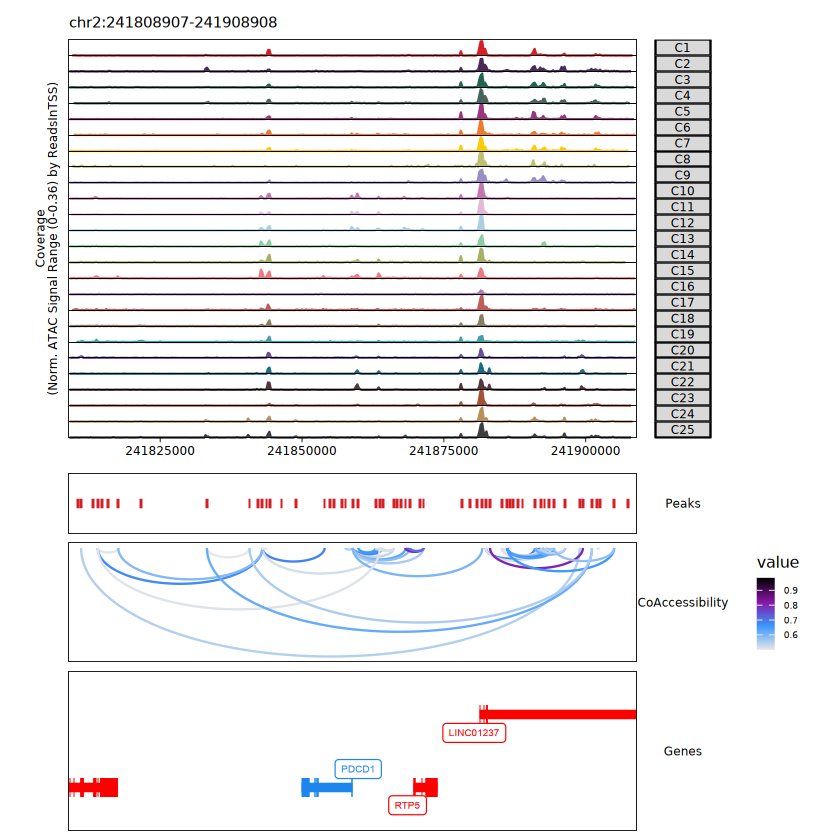

In [9]:
grid::grid.newpage()
grid::grid.draw(p$PDCD1)

In [10]:
p1 <- plotBrowserTrack(
    ArchRProj = proj, 
    groupBy = "majorType", 
    geneSymbol = markerGenes, 
    upstream = 50000,
    downstream = 50000,
    loops = getCoAccessibility(proj)
)

ArchR logging to : ArchRLogs/ArchR-plotBrowserTrack-3ff4d156b2ae6a-Date-2025-04-20_Time-14-03-08.062442.log
If there is an issue, please report to github with logFile!

2025-04-20 14:03:08.167667 : Validating Region, 0.002 mins elapsed.



GRanges object with 10 ranges and 2 metadata columns:
       seqnames              ranges strand |     gene_id      symbol
          <Rle>           <IRanges>  <Rle> | <character> <character>
   [1]    chr12   68154768-68159747      - |        3458        IFNG
   [2]     chr2 241849881-241858908      - |        5133       PDCD1
   [3]     chr5 157085832-157142869      - |       84868      HAVCR2
   [4]     chr3 114276913-114310288      + |      201633       TIGIT
   [5]     chr2 203867786-203873960      + |        1493       CTLA4
   [6]    chr12     6772512-6778455      + |        3902        LAG3
   [7]     chr4   77511753-77611834      + |       10563      CXCL13
   [8]    chr10   95711779-95869695      + |         953      ENTPD1
   [9]     chr8   58805418-59119208      - |        9760         TOX
  [10]     chr3 112332347-112362812      + |        4345       CD200
  -------
  seqinfo: 24 sequences from hg38 genome


2025-04-20 14:03:08.324599 : Adding Bulk Tracks (1 of 10), 0.004 mins elapsed.



R_zmq_msg_send errno: 4 strerror: Interrupted system call


2025-04-20 14:03:11.132914 : Adding Feature Tracks (1 of 10), 0.051 mins elapsed.

2025-04-20 14:03:11.244428 : Adding Loop Tracks (1 of 10), 0.053 mins elapsed.

2025-04-20 14:03:13.471704 : Adding Gene Tracks (1 of 10), 0.09 mins elapsed.

2025-04-20 14:03:14.406003 : Plotting, 0.106 mins elapsed.

2025-04-20 14:03:16.480438 : Adding Bulk Tracks (2 of 10), 0.14 mins elapsed.



R_zmq_msg_send errno: 4 strerror: Interrupted system call


2025-04-20 14:03:21.236069 : Adding Feature Tracks (2 of 10), 0.22 mins elapsed.

2025-04-20 14:03:21.34932 : Adding Loop Tracks (2 of 10), 0.221 mins elapsed.

2025-04-20 14:03:22.506828 : Adding Gene Tracks (2 of 10), 0.241 mins elapsed.

2025-04-20 14:03:23.369642 : Plotting, 0.255 mins elapsed.

2025-04-20 14:03:25.778962 : Adding Bulk Tracks (3 of 10), 0.295 mins elapsed.



R_zmq_msg_send errno: 4 strerror: Interrupted system call


2025-04-20 14:03:28.544495 : Adding Feature Tracks (3 of 10), 0.341 mins elapsed.

2025-04-20 14:03:28.653216 : Adding Loop Tracks (3 of 10), 0.343 mins elapsed.

2025-04-20 14:03:30.889874 : Adding Gene Tracks (3 of 10), 0.38 mins elapsed.

2025-04-20 14:03:31.320725 : Plotting, 0.388 mins elapsed.

2025-04-20 14:03:32.925487 : Adding Bulk Tracks (4 of 10), 0.414 mins elapsed.



R_zmq_msg_send errno: 4 strerror: Interrupted system call


2025-04-20 14:03:35.968127 : Adding Feature Tracks (4 of 10), 0.465 mins elapsed.

2025-04-20 14:03:36.056681 : Adding Loop Tracks (4 of 10), 0.467 mins elapsed.

2025-04-20 14:03:39.097478 : Adding Gene Tracks (4 of 10), 0.517 mins elapsed.

2025-04-20 14:03:39.487599 : Plotting, 0.524 mins elapsed.

2025-04-20 14:03:41.078875 : Adding Bulk Tracks (5 of 10), 0.55 mins elapsed.

2025-04-20 14:03:44.246532 : Adding Feature Tracks (5 of 10), 0.603 mins elapsed.

2025-04-20 14:03:44.353844 : Adding Loop Tracks (5 of 10), 0.605 mins elapsed.

2025-04-20 14:03:46.853994 : Adding Gene Tracks (5 of 10), 0.647 mins elapsed.

2025-04-20 14:03:47.282082 : Plotting, 0.654 mins elapsed.

2025-04-20 14:03:48.850589 : Adding Bulk Tracks (6 of 10), 0.68 mins elapsed.



R_zmq_msg_send errno: 4 strerror: Interrupted system call


2025-04-20 14:03:52.652943 : Adding Feature Tracks (6 of 10), 0.743 mins elapsed.

2025-04-20 14:03:52.871173 : Adding Loop Tracks (6 of 10), 0.747 mins elapsed.

2025-04-20 14:03:53.376966 : Adding Gene Tracks (6 of 10), 0.755 mins elapsed.

2025-04-20 14:03:53.794885 : Plotting, 0.762 mins elapsed.

2025-04-20 14:03:55.726268 : Adding Bulk Tracks (7 of 10), 0.794 mins elapsed.



R_zmq_msg_send errno: 4 strerror: Interrupted system call


2025-04-20 14:03:58.301376 : Adding Feature Tracks (7 of 10), 0.837 mins elapsed.

2025-04-20 14:03:58.397319 : Adding Loop Tracks (7 of 10), 0.839 mins elapsed.

2025-04-20 14:03:58.52298 : Adding Gene Tracks (7 of 10), 0.841 mins elapsed.

2025-04-20 14:03:58.960766 : Plotting, 0.848 mins elapsed.

2025-04-20 14:04:00.395469 : Adding Bulk Tracks (8 of 10), 0.872 mins elapsed.



R_zmq_msg_send errno: 4 strerror: Interrupted system call


2025-04-20 14:04:03.122553 : Adding Feature Tracks (8 of 10), 0.918 mins elapsed.

2025-04-20 14:04:03.225732 : Adding Loop Tracks (8 of 10), 0.919 mins elapsed.

2025-04-20 14:04:03.497284 : Adding Gene Tracks (8 of 10), 0.924 mins elapsed.

2025-04-20 14:04:03.976094 : Plotting, 0.932 mins elapsed.

2025-04-20 14:04:06.624969 : Adding Bulk Tracks (9 of 10), 0.976 mins elapsed.



R_zmq_msg_send errno: 4 strerror: Interrupted system call


2025-04-20 14:04:09.32789 : Adding Feature Tracks (9 of 10), 1.021 mins elapsed.

2025-04-20 14:04:09.427518 : Adding Loop Tracks (9 of 10), 1.023 mins elapsed.

2025-04-20 14:04:10.018997 : Adding Gene Tracks (9 of 10), 1.033 mins elapsed.

2025-04-20 14:04:10.429626 : Plotting, 1.039 mins elapsed.

2025-04-20 14:04:11.7653 : Adding Bulk Tracks (10 of 10), 1.062 mins elapsed.



R_zmq_msg_send errno: 4 strerror: Interrupted system call


2025-04-20 14:04:14.651227 : Adding Feature Tracks (10 of 10), 1.11 mins elapsed.

2025-04-20 14:04:14.746543 : Adding Loop Tracks (10 of 10), 1.111 mins elapsed.

2025-04-20 14:04:15.237948 : Adding Gene Tracks (10 of 10), 1.12 mins elapsed.

2025-04-20 14:04:15.608023 : Plotting, 1.126 mins elapsed.

ArchR logging successful to : ArchRLogs/ArchR-plotBrowserTrack-3ff4d156b2ae6a-Date-2025-04-20_Time-14-03-08.062442.log



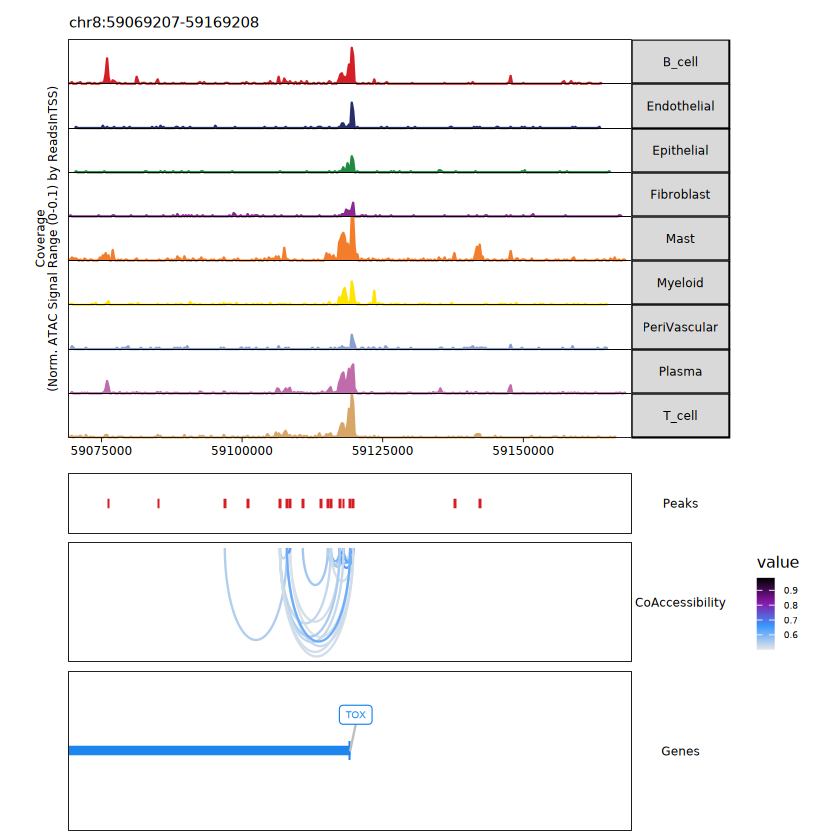

In [12]:
grid::grid.newpage()
grid::grid.draw(p1$TOX)

In [ ]:
plotPDF(plotList = p, 
    name = "Plot-Tracks-Marker-Genes-with-CoAccessibility.pdf", 
    ArchRProj = projHeme5, 
    addDOC = FALSE, width = 5, height = 5)

In [27]:
proj@cellColData$majorType <- factor(proj@cellColData$majorType,
                                     levels = c("Epithelial", "T cells", "B cells", 
                                                "Myeloid", "Plasmablast", "Mast", 
                                                "Endothelial", "Fibroblast", "PeriVascular"))

In [30]:
levels(proj@cellColData$majorType)

[1] "Epithelial"   "T cells"      "B cells"      "Myeloid"      "Plasmablast" 
[6] "Mast"         "Endothelial"  "Fibroblast"   "PeriVascular"

In [19]:
# 定义要可视化的基因列表
marker_genes <- c("ERBB2", "CD3D", "PAX5", "ITGAM", "JCHAIN", "TBSB2", "KDR", "THY1", "RGS5")  

In [31]:
p <- plotBrowserTrack(
    ArchRProj = proj, 
    groupBy = "majorType", 
    geneSymbol = marker_genes,
    upstream = 50000,
    downstream = 50000
)

ArchR logging to : ArchRLogs/ArchR-plotBrowserTrack-12566a27b657b6-Date-2025-06-05_Time-09-07-10.068085.log
If there is an issue, please report to github with logFile!

2025-06-05 09:07:10.178232 : Validating Region, 0.002 mins elapsed.



GRanges object with 8 ranges and 2 metadata columns:
      seqnames              ranges strand |     gene_id      symbol
         <Rle>           <IRanges>  <Rle> | <character> <character>
  [1]    chr17   39687914-39728662      + |        2064       ERBB2
  [2]    chr11 118338954-118342744      - |         915        CD3D
  [3]     chr9   36833275-37034185      - |        5079        PAX5
  [4]    chr16   31259990-31332892      + |        3684       ITGAM
  [5]     chr4   70655541-70681817      - |        3512      JCHAIN
  [6]     chr4   55078477-55125589      - |        3791         KDR
  [7]    chr11 119417378-119424985      - |        7070        THY1
  [8]     chr1 163111121-163321894      - |        8490        RGS5
  -------
  seqinfo: 24 sequences from hg38 genome


2025-06-05 09:07:10.246007 : Adding Bulk Tracks (1 of 8), 0.003 mins elapsed.

2025-06-05 09:07:13.754914 : Adding Feature Tracks (1 of 8), 0.061 mins elapsed.

2025-06-05 09:07:13.827612 : Adding Gene Tracks (1 of 8), 0.063 mins elapsed.

2025-06-05 09:07:14.148157 : Plotting, 0.068 mins elapsed.

2025-06-05 09:07:15.564544 : Adding Bulk Tracks (2 of 8), 0.092 mins elapsed.

2025-06-05 09:07:19.19373 : Adding Feature Tracks (2 of 8), 0.152 mins elapsed.

2025-06-05 09:07:19.269283 : Adding Gene Tracks (2 of 8), 0.153 mins elapsed.

2025-06-05 09:07:19.571819 : Plotting, 0.158 mins elapsed.

2025-06-05 09:07:20.816539 : Adding Bulk Tracks (3 of 8), 0.179 mins elapsed.

2025-06-05 09:07:24.814868 : Adding Feature Tracks (3 of 8), 0.246 mins elapsed.

2025-06-05 09:07:24.889615 : Adding Gene Tracks (3 of 8), 0.247 mins elapsed.

2025-06-05 09:07:26.765633 : Plotting, 0.278 mins elapsed.

2025-06-05 09:07:27.755653 : Adding Bulk Tracks (4 of 8), 0.295 mins elapsed.

2025-06-05 09:07:30.32

In [32]:
plotPDF(p, name = "Total-Marker-Track", width = 5, height = 5, ArchRProj = proj, addDOC = FALSE)

Plotting Gtable!



NULL


Plotting Gtable!



NULL


Plotting Gtable!



NULL


Plotting Gtable!



NULL


Plotting Gtable!



NULL


Plotting Gtable!



NULL


Plotting Gtable!



NULL


Plotting Gtable!



NULL


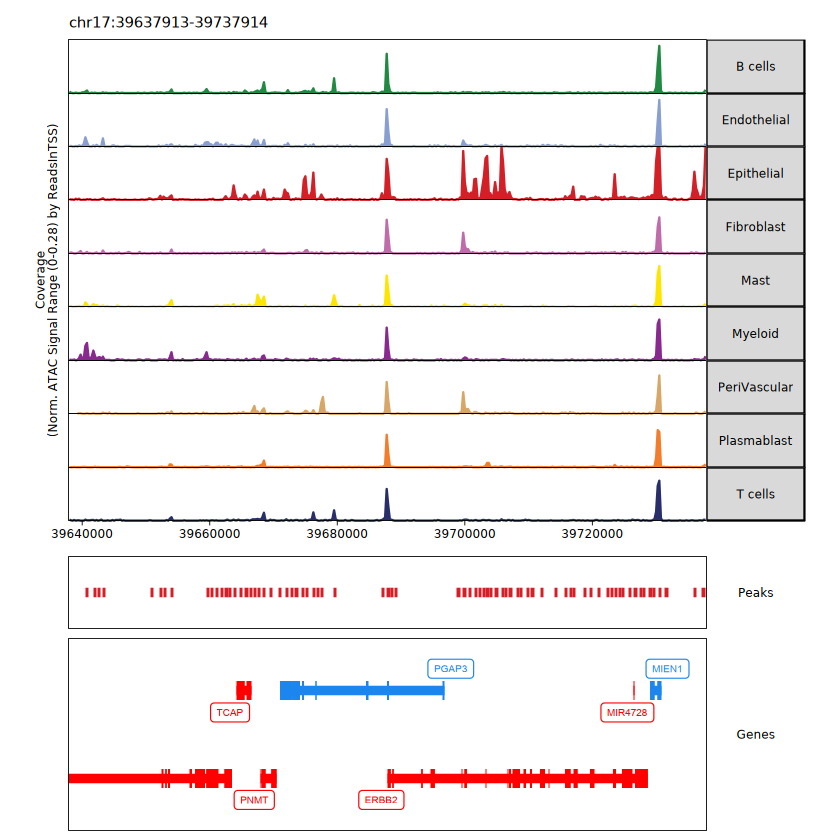

In [33]:
grid::grid.newpage()
grid::grid.draw(p$ERBB2)

In [38]:
after_cells <- getCellNames(ArchRProj = proj)[proj$neoadjuvant=="after_neoadjuvant"]
proj_after <- proj[after_cells,]

Dropping ImputeWeights Since You Are Subsetting Cells! ImputeWeights is a cell-x-cell Matrix!



In [40]:
before_cells <- getCellNames(ArchRProj = proj)[proj$neoadjuvant=="without_neoadjuvant"]
proj_before <- proj[before_cells,]

Dropping ImputeWeights Since You Are Subsetting Cells! ImputeWeights is a cell-x-cell Matrix!



ArchR logging to : ArchRLogs/ArchR-plotEmbedding-12566a41fcf8ba-Date-2025-06-05_Time-16-19-51.353309.log
If there is an issue, please report to github with logFile!



Getting UMAP Embedding

ColorBy = cellColData

Plotting Embedding

1 


ArchR logging successful to : ArchRLogs/ArchR-plotEmbedding-12566a41fcf8ba-Date-2025-06-05_Time-16-19-51.353309.log



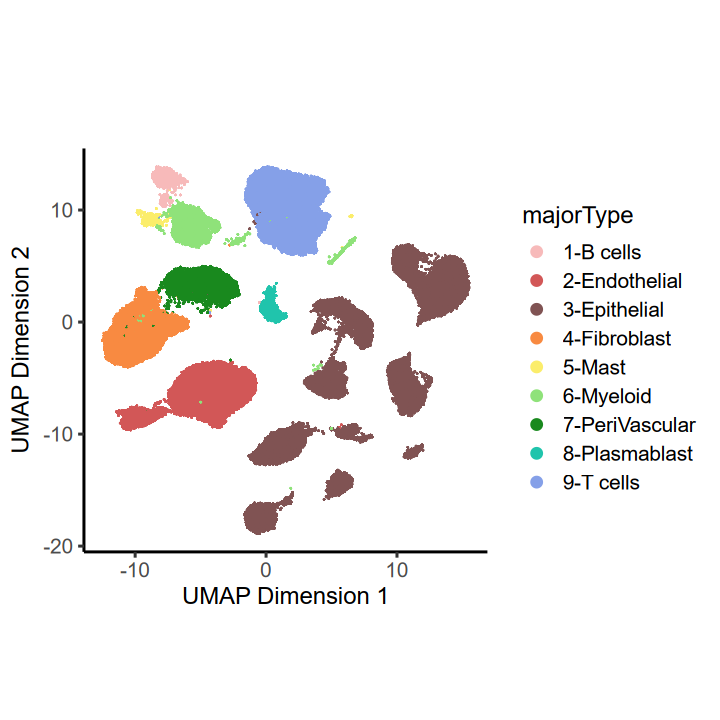

In [45]:
## cell type annotation
disc_pal <- c(
  "B cells" = "#F7BABA",  
  "Endothelial" = "#D25757",  
  "Epithelial" = "#805353",  
  "Fibroblast" = "#F88A41",  
  "Mast" = "#FBED6B",  
  "Myeloid" = "#8FE27A",   
  "PeriVascular" = "#19891E",  
  "Plasmablast" = "#20C4AC", 
  "T cells" = "#85A0E8"  
  )

options(repr.plot.height = 6, repr.plot.width = 6)
p1 <- plotEmbedding(
    ArchRProj = proj, 
    colorBy = "cellColData", 
    name = "majorType", 
    embedding = "UMAP",
    pal = disc_pal,
    size = 1,
    labelMeans = FALSE,
    colorTitle = "majorType",
    legendSize = 12,
    baseSize = 12
    )+
        theme_bw(base_size = 14) +
        theme(
            panel.border = element_blank(),
            panel.grid.major = element_blank(), # 移除主网格线
            panel.grid.minor = element_blank(),
            axis.line = element_line(colour = "black"), # 保留坐标轴线
            axis.text = element_text(size = 12),  # 修改坐标轴文字字体
            axis.title = element_text(size = 14), # 修改坐标轴标题字体
            legend.text = element_text(size = 12), # 修改图例文字字体
            legend.title = element_text(size = 14), # 修改图例标题字体
            plot.title = element_text(size = 16, hjust = 0.5) # 修改标题字体并居中
        )+
    labs(title = "") + guides(color = guide_legend(override.aes = list(shape = 16, size = 3))) 
p1


In [46]:
ggsave("total-UAMP.svg",plot = p1, device = "svg")

Saving 7 x 7 in image


ArchR logging to : ArchRLogs/ArchR-plotEmbedding-12566a6f648370-Date-2025-06-05_Time-16-20-07.233242.log
If there is an issue, please report to github with logFile!



Getting UMAP Embedding

ColorBy = cellColData

Plotting Embedding

1 


ArchR logging successful to : ArchRLogs/ArchR-plotEmbedding-12566a6f648370-Date-2025-06-05_Time-16-20-07.233242.log



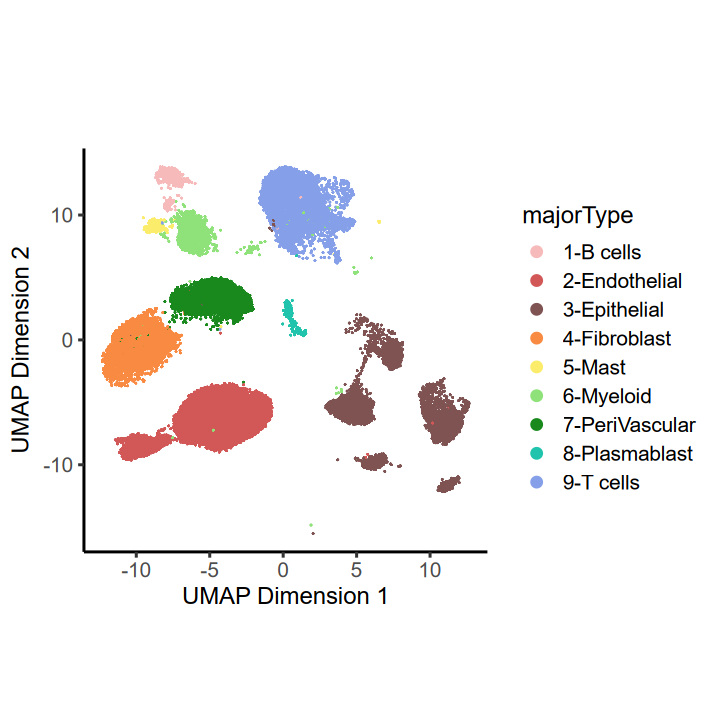

In [47]:
options(repr.plot.height = 6, repr.plot.width = 6)
p2 <- plotEmbedding(
    ArchRProj = proj_after, 
    colorBy = "cellColData", 
    name = "majorType", 
    embedding = "UMAP",
    pal = disc_pal,
    size = 1,
    labelMeans = FALSE,
    colorTitle = "majorType",
    legendSize = 12,
    baseSize = 12
    )+
        theme_bw(base_size = 14) +
        theme(
            panel.border = element_blank(),
            panel.grid.major = element_blank(), # 移除主网格线
            panel.grid.minor = element_blank(),
            axis.line = element_line(colour = "black"), # 保留坐标轴线
            axis.text = element_text(size = 12),  # 修改坐标轴文字字体
            axis.title = element_text(size = 14), # 修改坐标轴标题字体
            legend.text = element_text(size = 12), # 修改图例文字字体
            legend.title = element_text(size = 14), # 修改图例标题字体
            plot.title = element_text(size = 16, hjust = 0.5) # 修改标题字体并居中
        )+
    labs(title = "") + guides(color = guide_legend(override.aes = list(shape = 16, size = 3))) 
p2

In [48]:
ggsave("after-UAMP.svg",plot = p2, device = "svg")

Saving 7 x 7 in image


ArchR logging to : ArchRLogs/ArchR-plotEmbedding-12566a235529a0-Date-2025-06-05_Time-16-20-13.724085.log
If there is an issue, please report to github with logFile!



Getting UMAP Embedding

ColorBy = cellColData

Plotting Embedding

1 


ArchR logging successful to : ArchRLogs/ArchR-plotEmbedding-12566a235529a0-Date-2025-06-05_Time-16-20-13.724085.log



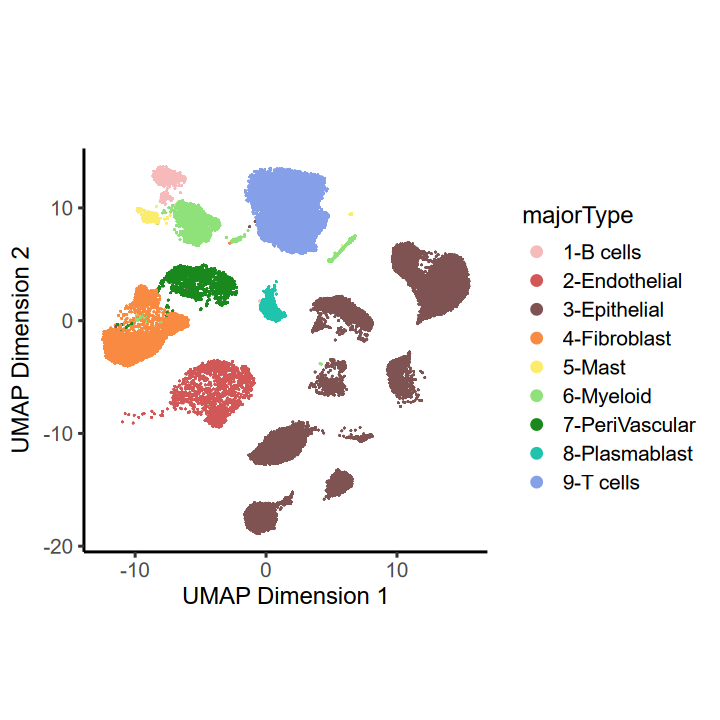

In [49]:
options(repr.plot.height = 6, repr.plot.width = 6)
p3 <- plotEmbedding(
    ArchRProj = proj_before, 
    colorBy = "cellColData", 
    name = "majorType", 
    embedding = "UMAP",
    pal = disc_pal,
    size = 1,
    labelMeans = FALSE,
    colorTitle = "majorType",
    legendSize = 12,
    baseSize = 12
    )+
        theme_bw(base_size = 14) +
        theme(
            panel.border = element_blank(),
            panel.grid.major = element_blank(), # 移除主网格线
            panel.grid.minor = element_blank(),
            axis.line = element_line(colour = "black"), # 保留坐标轴线
            axis.text = element_text(size = 12),  # 修改坐标轴文字字体
            axis.title = element_text(size = 14), # 修改坐标轴标题字体
            legend.text = element_text(size = 12), # 修改图例文字字体
            legend.title = element_text(size = 14), # 修改图例标题字体
            plot.title = element_text(size = 16, hjust = 0.5) # 修改标题字体并居中
        )+
    labs(title = "") + guides(color = guide_legend(override.aes = list(shape = 16, size = 3))) 
p3

In [51]:
ggsave("before-UAMP.svg",plot = p3, device = "svg")

Saving 7 x 7 in image


In [16]:
## 保存结果
saveArchRProject(proj, load = FALSE)

Saving ArchRProject...

